In [0]:
import math
import pandas as pd
import numpy as np
import calendar
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import dateutil.parser as dparser

from matplotlib.dates import DateFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, mutual_info_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# Download the Data 
Keep this if you are working in Google Colab. Delete this if you are working on your own computer and have the data downloaded already. 

In [8]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vMDKGd_CmuiMF3DLVPg2zCJv83YY7wIQ' -O USvideos.csv

--2020-02-03 06:12:19--  https://docs.google.com/uc?export=download&id=1vMDKGd_CmuiMF3DLVPg2zCJv83YY7wIQ
Resolving docs.google.com (docs.google.com)... 173.194.79.100, 173.194.79.139, 173.194.79.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i847c9m5un4nuqm7913203jis7drvore/1580709600000/12415169093740643693/*/1vMDKGd_CmuiMF3DLVPg2zCJv83YY7wIQ?e=download [following]
--2020-02-03 06:12:21--  https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i847c9m5un4nuqm7913203jis7drvore/1580709600000/12415169093740643693/*/1vMDKGd_CmuiMF3DLVPg2zCJv83YY7wIQ?e=download
Resolving doc-0c-94-docs.googleusercontent.com (doc-0c-94-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-0c-94-docs.googleusercontent.com (doc-0c-94-

# Introduction to Youtube
I'm using [Trending videos on Youtube](https://www.kaggle.com/datasnaek/youtube-new#USvideos.csv) **USVideo.csv** dataset. The file contains 40,949 rows and each row of this file represents a single video on **YouTube.com** in US. Each row in our dataset represents a single video uploaded to YouTube, and each row contains 16 columns:

- **video_id**: Unique ID of video
- **trending_date**: The most popular date of that video
- **title**: Title of the loan application (written by the borrower)
- **channel_title**: The channel video was posted
- **category_id**: Unique ID of channel
- **publish_time**: Specific time the video was posted
- **tags**: What kind of hashtags are using for the video
- **views**: Number of views
- **likes**: Number of likes
- **dislikes**: Number of dislikes
- **comment_count**: Number of comments
- **thumbnail_link**: The URL link of video
- **comments_disabled**: Whether the video disable comments or not (FASLE=Comments Enabled; TRUE=Comments Disabled)
- **ratings_disabled**: Whether the video disable ratings or not (FASLE=Ratings Enabled; TRUE=Ratings Disabled)
- **video_error_or_removed**: Whether the video has error/was removed or not (FASLE=Video Exist; TRUE=Video Error/Removed)
- **description**: Detailed description about the video content
 
As working on the digital ranking team of Youtube, my goal is to assess how accurate the model is going to predict Youtube videos' recommendation.

In [13]:
YT = pd.read_csv("USvideos.csv") 
YT.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


# Question 1:


There are two steps of questions include:
- How many of those trending videos are going to be shouted out?
- How much is the prediction accurate?

# Question 2: 
I trained a decision tree classifier to predict loan acceptance based on the features provided. This report includes the following information:
- Class distribution of the outcome labels.
- List of features you used from the data, including their name and data type (numeric or
nominal). For each feature, provide min, mean, and max values (if the feature is numeric) or
list all possible labels (if the feature is nominal).
- Performance of the trained classifier, using metrics like accuracy, kappa, precision, and recall. You must provide a labeled confusion matrix.
- List of hyperparameter settings for the decision tree.

## Identify Pre-requisites
First, I walk-throughed my thinking project goals as the following:

1. Dataset: 2-year data from 2017-2018 includes 40k+ total rows and each row represents one lending record; 

2. Task: Predict if a video is popular or not; 

3. Class: categorical **pop_video_spread** labels (very high/high/rlow)

4. Numeric features: **likes**, **dislikes**, **comment_count**; nominal feature: **comments_disabled**, **ratings_disabled**

Then I cleaned the data as the following:

In [80]:
# Delete all rows with column 'video_error_or_removed' has value True
indexNames = YT[ (YT['video_error_or_removed'] == True) ].index
YT.drop(indexNames , inplace=True)

# Define the popularity based on the difference between publish date and trending date
YT["trending_date_new"] = YT["trending_date"].str[3:5].astype(int)
YT['publish_time_new'] = pd.to_datetime(YT['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
YT['publish_date_new'] = YT["publish_time_new"].apply(lambda x: x.day)

YT['pop_date_diff'] = YT["trending_date_new"] - YT['publish_date_new'] 
YT.describe()

,category_id,views,likes,dislikes,comment_count,trending_date_new,publish_date_new,pop_date_diff,publish_year_new
count,40926.000000,4.092600e+04,4.092600e+04,4.092600e+04,4.092600e+04,40926.000000,40926.000000,40926.000000,40926.000000
mean,19.977814,2.361180e+06,7.428103e+04,3.712676e+03,8.450109e+03,15.858745,15.942286,-0.083541,2017.714582
std,7.562658,7.395925e+06,2.289406e+05,2.903779e+04,3.744065e+04,8.848249,8.432693,11.520475,0.604181
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,-30.000000,2006.000000
25%,17.000000,2.422892e+05,5.424000e+03,2.020000e+02,6.140000e+02,8.000000,9.000000,1.000000,2017.000000
50%,24.000000,6.817090e+05,1.808550e+04,6.310000e+02,1.856000e+03,16.000000,16.000000,4.000000,2018.000000
75%,25.000000,1.823349e+06,5.543025e+04,1.938000e+03,5.758000e+03,23.000000,23.000000,6.000000,2018.000000
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,31.000000,31.000000,30.000000,2018.000000


In [115]:
# Create a column to determine the popularity of video
def frequency(x):
    if x <= 2:
        return "high"
    if x > 2:
        return "low"
    
YT["pop_spread"] = YT["pop_date_diff"].apply(frequency)

# Check the distribution of the weather data and preview the dataframe
print(YT["pop_spread"].value_counts())
YT.head()

low     24947
high    15979
Name: pop_spread, dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,trending_date_new,publish_time_new,publish_date_new,pop_date_diff,pop_date_frequency,pop_date_spread,publish_year_new,pop_spread
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,14,2017-11-13 17:13:01,13,1,very high,very high,2017,high
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",14,2017-11-13 07:30:00,13,1,very high,very high,2017,high
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,14,2017-11-12 19:05:24,12,2,high,high,2017,high
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,14,2017-11-13 11:00:04,13,1,very high,very high,2017,high
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,14,2017-11-12 18:01:41,12,2,high,high,2017,high


In [116]:
# Show how our features data present
YT_features = YT.loc[:,["likes","dislikes","comment_count","comments_disabled","ratings_disabled"]]
YT_features.describe()

,likes,dislikes,comment_count
count,4.092600e+04,4.092600e+04,4.092600e+04
mean,7.428103e+04,3.712676e+03,8.450109e+03
std,2.289406e+05,2.903779e+04,3.744065e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.424000e+03,2.020000e+02,6.140000e+02
50%,1.808550e+04,6.310000e+02,1.856000e+03
75%,5.543025e+04,1.938000e+03,5.758000e+03
max,5.613827e+06,1.674420e+06,1.361580e+06


## Creating the Train/Test Split

Now that we know that using a train/test split is important for properly evaluating our models, let's consider some different ways to potentially create that train/test split. We'll see that we have to be careful when creating our train/test split to make sure that it makes sense. 

In [117]:
# Calculate how often to send data to the test set (in our case for an 80/20 train/test split)
test_size = 0.2
test_modulus = int(1/test_size)

# Set 4/5 data points from each set of 5 data points to be in the train set
YT_train = YT.iloc[YT.index % test_modulus != 0]
# Set the remaining 1 data point from each set of 5 data points to be in the test set
YT_test = YT.iloc[YT.index % test_modulus == 0]

# Lets confirm the size of the train and test set are still about right
print("Size of train data:", len(YT_train))
print("Size of test  data:", len(YT_test))

# Lets examine the distribution of the months in the two datasets
print("Training set months:")
print(YT_train["publish_date_new"].value_counts())
print("Test set months:")
print(YT_test["publish_date_new"].value_counts())

Size of train data: 32742
Size of test  data: 8184
Training set months:
20    1544
22    1381
15    1335
8     1262
21    1262
23    1235
13    1227
16    1212
18    1203
14    1199
19    1187
12    1138
5     1106
1     1102
26    1096
27    1055
6      994
29     986
24     983
10     954
4      950
9      950
11     930
7      902
30     901
17     884
2      883
28     861
25     857
3      706
31     457
Name: publish_date_new, dtype: int64
Test set months:
20    380
21    342
22    337
15    317
16    317
14    311
13    305
8     303
23    299
18    288
5     286
27    277
26    275
19    272
11    265
12    259
9     254
1     252
2     245
4     244
6     241
24    239
29    238
10    231
17    225
30    224
7     224
25    217
28    213
3     181
31    123
Name: publish_date_new, dtype: int64


In [118]:
numeric_features = ["likes","dislikes","comment_count"]
nominal_features = ["comments_disabled","ratings_disabled"]

feature_set = numeric_features + nominal_features

X = YT.loc[:, feature_set]
X = pd.get_dummies(X)

y = YT["pop_spread"]

# Use scikit-learn to create our train/test split and train our decision tree
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32740, 5)
(8186, 5)
(32740,)
(8186,)


## Comparing training-set results to test-set results

Lets see how we can use the train/test split we created to better understand and compare different models. 

In [119]:
# Create lists of possible features (Same as in Day 1)
numeric_features = ["likes","dislikes","comment_count"]
nominal_features = ["comments_disabled","ratings_disabled"]

feature_set = numeric_features + nominal_features

feature_sets = {
    "numeric": numeric_features,
    "nominal": nominal_features,
    "all": numeric_features + nominal_features
}

# We'll keep track of which classifier was the best
best = 0
best_name = None
best_actual = None
best_predictions = None

test_accuracies = []
train_accuracies = []

# For each feature set, we evaluate our model on both the train and the test set
for set_name, feature_set in feature_sets.items():

    # Create a dummyset with only the features in our feature set
    X = YT.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = YT["pop_spread"]

    # Use scikit-learn to create our train/test split and train our decision tree
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)

    # Calculate our accuracy on the train and test sets
    train_pred = model.predict(X_train)
    train_accuracy = 100*accuracy_score(y_train, train_pred)
    
    test_pred = model.predict(X_test)
    test_accuracy = 100*accuracy_score(y_test, test_pred)

    # Keep track of the best model on the test set
    if test_accuracy > best:
        best = test_accuracy
        best_name = set_name
        best_actual = y_test
        best_predictions = test_pred
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    # Display the accuracy on the train and test set for each model
    print(f"Results for {set_name}:")
    print(f"Accuracy on the train set: {train_accuracy:.1f}")
    print(f"Accuracy on the test set: {test_accuracy:.1f}")
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")  

Results for numeric:
Accuracy on the train set: 99.8
Accuracy on the test set: 68.2
------------------------
Results for nominal:
Accuracy on the train set: 60.8
Accuracy on the test set: 61.5
------------------------
Results for all:
Accuracy on the train set: 99.8
Accuracy on the test set: 68.3
------------------------
Best feature set is: all 
With: 68.3% accuracy.


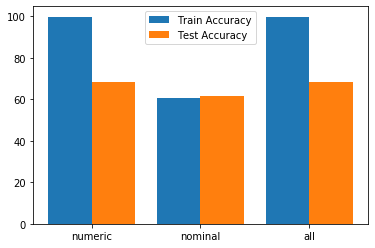

In [120]:
locs = np.arange(len(test_accuracies))

ax = plt.gca()
ax.bar(locs-0.2, train_accuracies, width=0.4)
ax.bar(locs+0.2, test_accuracies, width=0.4)
ax.set_xticks(locs)
ax.set_xticklabels(list(feature_sets.keys()))
ax.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

## Metrics of Model Quality

While accuracy is great some of the time, there are many cases where it is not a good metric for understanding the performance of our models. Lets explore some alternate methods for evaluating our models and figure out when we should be using them. 

In [0]:
# Lets keep the predictions from the best tree that we found to use in this section
predictions = best_predictions
actual = np.array(list(best_actual))

### Accuracy

$$ accuracy = \frac{correct \space predictions}{total \space predictions} \times 100 $$

In [122]:
# Calculating accuracy with scikit-learn
accuracy = accuracy_score(actual, predictions)
print(f"scikit-learn accuracy metric: {100*accuracy:.1f}")

scikit-learn accuracy metric: 68.3


### Confusion Matrix

The confusion matrix is a great way to visualize where our model is making errors. Elements on the diagonal represent correct predictions. Elements off the diagonal represent that the model predicted the wrong class.

In [123]:
# Generating our confusion matrix manually

# Helper function to display our confusion matrix nicely
def matrix_print(matrix):
    print("           Predictions")
    print(f"Actual    |", end='')
    for pred in list(matrix.keys()):
        print(f"{str(pred).rjust(10)}|", end='')
    print()
    for act in list(matrix.keys()):
        print(f"{str(act).rjust(10)}|", end='')
        for pred in list(matrix.keys()):
            cell = matrix[pred][act]
            print(f"{str(cell).rjust(10)}|", end='')
        print()

# Actually computing our confusion matrix         
def build_confusion_matrix(actual, predictions):
    confusion_matrix = {}
    for pred_value in np.unique(predictions):
        confusion_matrix[pred_value] = {}
        for act_value in np.unique(actual):
            cell_count = 0
            for i in range(len(actual)):
                if predictions[i] == pred_value and actual[i] == act_value:
                    cell_count += 1
            confusion_matrix[pred_value][act_value] = cell_count
    return confusion_matrix

conf_matrix = build_confusion_matrix(actual, predictions)
matrix_print(conf_matrix)

           Predictions
Actual    |      high|       low|
      high|      1829|      1322|
       low|      1276|      3759|


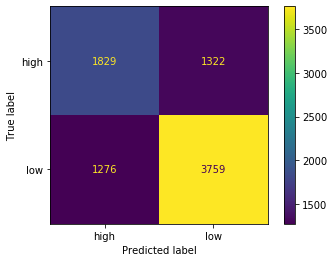

In [128]:
# Generating our confusion matrix with scikit-learn
conf_matrix = confusion_matrix(actual, predictions)
ConfusionMatrixDisplay(conf_matrix, ["high", "low"]).plot(values_format='.4g')
plt.show()

### Cohen's Kappa

$$ \kappa = \frac{accuracy - chance \space agreement}{1 - chance \space agreement}$$


In [129]:
# Calculating Kappa with scikit-learn
kappa = cohen_kappa_score(actual, predictions)
print(f"scikit-learn kappa metric: {kappa:.3f}")

scikit-learn kappa metric: 0.328


### Precision and Recall

$$ Precision = \frac{sucessful \space predictions}{predicted \space positives}$$
$$ Recall = \frac{sucessful \space predictions}{actual \space positives}$$

In [130]:
# Compute Precision and Recall with a Confusion Matrix
conf_matrix = build_confusion_matrix(actual, predictions)

successful_positives = conf_matrix["high"]["high"]
predicted_positives = 0
for a in conf_matrix["high"].keys():
    predicted_positives += conf_matrix["high"][a]

precision = successful_positives / predicted_positives
print(f"Precision: {precision:.3f}")

actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p]["high"]
    
recall = successful_positives / actual_positives
print(f"Recall: {recall:.3f}")

Precision: 0.589
Recall: 0.580


# Question 3: 

Is the decision tree that you trained accurate enough to be used for each of the two business purposes you proposed in question 1? Why or why not?

First, we can tell from Question 2's Identify Pre-requisites Answers:
1. Likes are more normally distributed than dislikes; dislikes are far more left-skewed than likes
2. People's are generally a little bit more likely to comment than dislike

Second, after comparing trained and test dataset, we can tell that while 99.8% accuracy is pretty great. This is an example of more data having more information gain and being better and an example of how our decision tree algorithm does cover to the optimal tree.

Thrid, the metric quality shows:
- 68.3% scikit-learn accuracy metric and 0.328 kappa metric
- 1,829 true positive, 1,322 false positive, 1,276 false negative, and 3,759 true negative
- 0.589 precision and 0.580 recall

Recall number tells me that this model can actually find relevant cases within a dataset, which answered my first question: `58.0% of those trending videos are going to be shouted out`. 

But `how much is the prediction accurate?`. Precision tells me that a classification model can actually identify 58.9% relevant data points in prediction, which means `only 58.9% the model is accurate`. It is relatively low. Therefore, the model still has space to improve and we could train by logistic regression and optimal hyperparameters with Gini and entropy together in the future.
